# Neural Style Transfer: Wall-e in Starry Night 

The following notebook will implement  [**A Neural Algorithm of Artistic Style**](https://arxiv.org/pdf/1508.06576.pdf) to combine style and content of 2 different images to create a new artistic image.

## 1. Import libraries and images


In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import IPython.display as display

import tensorflow as tf
from tensorflow.keras import models
from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array

Below are 2 images: content and style image. Each will contribute to the final image which will be a image containing Wall-e in the style of Starry night.

In [6]:
# define image path
content_path = "/content/wall_e_5.jpeg"
style_path = "/content/starry_night.jpeg"


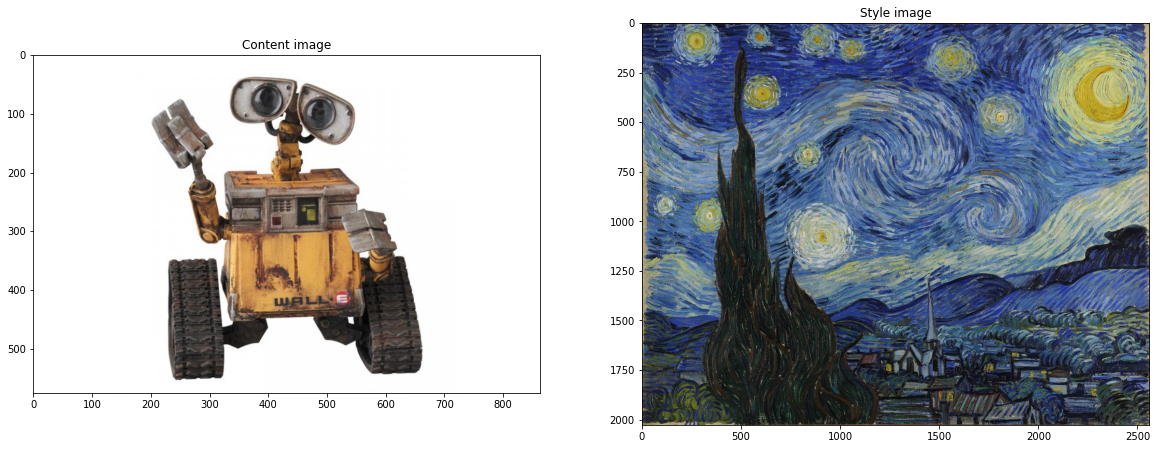

In [7]:
# Display image inputs
plt.figure(figsize=(20,20))

content = load_img(content_path)
style = load_img(style_path)

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style image')
plt.show()

Next, we are writing a function to load image, apply transformation to scale images that can then be used to feed in a pretrained VGG-19 model for features extraction.

In [ ]:
# define a function take in image path and return a preprocessed image
# fixed height =400, fixed width proportioned with fixed height

def load_preprocess_image(path):
    # define target size
    width, height = load_img(path).size
    fixed_height = 400
    fixed_width = int(width *fixed_height/height)
    #load image with pre-defined size
    img = load_img(path, target_size = (fixed_height, fixed_width))
    # image to tensor and add 1st dimension for batch size
    img = img_to_array(img)
    img= np.expand_dims(img, axis = 0)
    # preprocess image to feed in Pretrained model VGG-19
    img =vgg19.preprocess_input(img)
    return img

Let's transform images to tensors!

In [8]:
# preprocess input images
content_image = load_preprocess_image(content_path)
style_image = load_preprocess_image(style_path)

Next, we will prepare a function to transform tensor back to images. This function will be used at the end of the notebook to display the new image generated by the algorithm.  
Since the range of image pixel values is normalised to be zero-centered and color channels are in order BGR, they will be scale back to range [0,255] and order of RGB.

In [9]:
# define deprocess_image function

def deprocess_image(img): 
  #make sure the final shape is 3-D
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
    assert len(x.shape) == 3
  if len(x.shape) != 3:
    raise ValueError("Invalid input")
  # Rescale mean value to each color channel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # Return image in RGB order
  x = x[:, :, ::-1] # to RGB
  # Clip values to have min of 0 and max of 255 in unit8 dtype
  x = np.clip(x, 0, 255).astype('uint8') 
  return x

## 2. Model
In this section, we will write necessary functions to extract features from input images, cost function to compute gradient, define gradient calculating function and final put-together function to return generated image.

### 2.1 Feature extraction
In this section, we will employ VGG-19, a pretrained CNN model, as proposed in the paper, to extract features of content and style images.  
The purpose is that generated image to have those extracted features so that it will bear resemblance with input images.  


In order to extract content of the image, we want to extract the most arbitrary complex features returned by CNN. This will be achieved by extracting feature from the last layer of the network: block 5 (please note that this layer name depends on network architecture).  

In contrary to content, as for style features, we want to extract many arbitrary more simple patterns from the images, such as angles, shapes, ect. All of 5 blocks of the networks outputs will be returned for this purpose. 

In [10]:
# Choose final Conv block of VGG-19 to extract content from content image
content_layers = ['block5_conv2'] 

# Choose many Conv blocks of VGG-19 to extract style from style image
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

Next, let's import pretrain VGG-19 model 

In [12]:
# import pre-trained VGG-19 model and write a fucntion to return it
def my_model():
  vgg = vgg19.VGG19(include_top=False, weights='imagenet')
  # no weight will be trained
  vgg.trainable = False
    
  content_layers = ['block5_conv2'] 
  style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]
  # Get output from style and content layers
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  # Return a combine output of style and content
  outputs = style_outputs + content_outputs

  return models.Model(vgg.input, outputs)

The next function is to extract features after feeding input image to pre-trained network. The result will be matrices contains style and content.

In [13]:
def get_features(model, content_image, style_image):
  # extract features from content and style image using pretrained VGG19

  style_outputs = model(style_image) 
  content_outputs = model(content_image)
  
  # extract style and content feature seperately from each image
  # style: all 5 blocks, slice matrix 4-d to 3-d, remove batch dimension
  style_features = [style_layer[0] for style_layer in style_outputs[:5]]
  # content: block 5th, remove batch dimension, 4d => 3d matrix
  content_features = content_outputs[5:][0] 
  return style_features, content_features

### 2.2 Define lost function  
In this section, we will define functions to calculate content loss and style loss. The smaller these losses are, the more the generated image will bear resemblance to input images in term of style and content.  


Content loss: input of this function is content matrices of content input image and generated image.  
MSE will be employed to calculate loss.  
Please note that tf.reduce_mean is used instead of tf.reduce_sum for gradient calculation stability.

In [19]:
# Define content loss between content image and generated image
def content_loss_fnc(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

Gram_matrix:
- In order to calculate Style_loss, we need to calculate Style matrix (Gram matrix)
- Style matrix is calculated by multiply filters matrix with its transpose.
- The purpose is to find the common features (style) of the image: correlation between filter responses.

In [20]:
# calculate Gram matrix
def gram_matrix(input_tensor):
  # find scaling factor
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  # matrix multiplication with its transpose
  gram = tf.matmul(a, a, transpose_a=True)
  # return scaled gram_matrix 
  return gram / tf.cast(n, tf.float32)
    
    


Style_loss:  MSE is employed as in content_loss, however, an extra constant recommended by author will be added to scale the value.

In [21]:
# compute style_loss:

def style_loss_fnc(gram_gen, gram_org):
  constant = (1/2 *(400 * 600 * 3)) **2 # recommened by author of the paper
  style_loss = constant * tf.reduce_mean(tf.square(gram_gen-gram_org))
  return style_loss
    

Total loss function:
- This is the combination of content and style losses. And will be fed into Gradient_function to minimzed.
- Replace alpha and beta (weight for each loss) for different effect on the generated photo.  
- If clear content is more favoured then alpha will be larger than beta and vice versa.


In [22]:
# all_loss function take in model, generated image, style feature(gram_matrix),
# content feature, alpha and beta
def all_loss(model,generated_image, grams_org, content_org, alpha = 1, beta = 10):
  # initial loss = 0
  style_loss = 0
  content_loss = 0
  style_weight = 0.2 #each layer contribute the same amount of weight 1/5=0.2
  content_weight = 1 
    
  
  # get features from generated image
  generated_img_outputs = model(generated_image)
  generated_img_style = generated_img_outputs[:5]
  generated_img_content = generated_img_outputs[5:][0]
  grams_gen = [gram_matrix(layer[0]) for layer in generated_img_style] 

  # Total style loss over 5 layers: each layer contribute the same weight = 0.2
  for gram_org, gram_gen in zip(grams_org, grams_gen):
    style_loss += style_weight * style_loss_fnc(gram_org, gram_gen)
        
  # Content loss
  content_loss += content_weight * content_loss_fnc(generated_img_content, content_org)

  #total loss
  total_loss = content_loss * alpha + style_loss * beta
  return total_loss, style_loss, content_loss

In this step, we will defind a compute_gradients function that calculates loss base on total loss with respect to generate_image.

In [23]:
# define function to compute gradient from total loss
def compute_grads(model,generated_image, grams_org, content_org):
    with tf.GradientTape() as tape: 
        total_loss,_,_ = all_loss(model,generated_image, grams_org, content_org)
        return tape.gradient(total_loss, generated_image)

## 3. Training 

### 3.1 Style_transfer function

Let's define a function that takes in inputs and interation number and return generated image

In [33]:
# define training function
def style_transfer(content_image, style_image, num_iterations=1000): 

  #instatiate model
  model = my_model() 
  for layer in model.layers:
    layer.trainable = False
  
  #Get feautures of content and style images:
  style_org, content_org = get_features(model, content_image, style_image)
  grams_org = [gram_matrix(style) for style in style_org]
  
  # instantiate generated image
  # ratio can be changed for different effect on generated_image 
  noise_image = np.random.uniform(-10,10,(1, content_image.shape[-3],content_image.shape[-2],content_image.shape[-1])).astype('float32')
  generated_image = noise_image * 0.2 + content_image * 0.8
  generated_image = tf.Variable(generated_image, dtype = tf.float32)

  # Choose Adam to be optimizer for this model, note that learning_rate
  # is larger than normal rate since we need larger step for high total loss value.
  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
  
  # instatiate best_loss and best_img value
  # bess_loss = floate('inf) as we want to compare to a unbounded positive value
  best_loss, best_img = float('inf'), None
   
 
 # Value for clipping 
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    total_loss, style_loss, content_loss = all_loss(model,generated_image, grams_org, content_org)
    grads= compute_grads(model,generated_image, grams_org, content_org)
    opt.apply_gradients([(grads, generated_image)])
    clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
    generated_image.assign(clipped)
    
    if total_loss < best_loss:
      # Update best loss and best image 
      best_loss = total_loss
      best_img = deprocess_image(generated_image.numpy())
      imgs.append(best_img)

    if i % 500 == 0:
      start_time = time.time()
      print('Iteration: {}'.format(i))        
      print(f' Total loss: {total_loss},style loss: {style_loss},content loss: {content_loss}, time: { time.time() - start_time}')
    
  return best_img, best_loss, imgs

### 3.2 Training and return results

Let's run 5000 iterations to see generated image. The result is the best image, best loss result and an array contain all images generated during training process.

In [34]:
best_img, best_loss,imgs = style_transfer(content_image, style_image, num_iterations=5000)

Iteration: 4500
 Total loss: 3.0482560751543255e+18,style loss: 3.048256143873802e+17,content loss: 3754.21875, time: 0.0029821395874023438
Total time: 2798.4507s


Return the final best image.

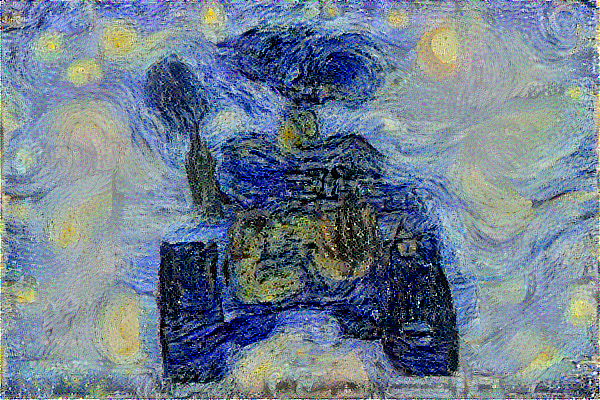

In [35]:
Image.fromarray(best_img)

Next, we will compare final image and images generated half way to analyse the difference. From there, we can decide how many iteration is enough for our desired result.

In [36]:
# Save the image
Image.fromarray(best_img).save('wall_e_gen_starrynight.png')

In [39]:
# inspect number of returned images
len(imgs)

4423

As seen below, the differnce between the 2 generated images is more defined content shape and stronger color shade. The final image has a stronger effect of original style and content since its losses are lower. 

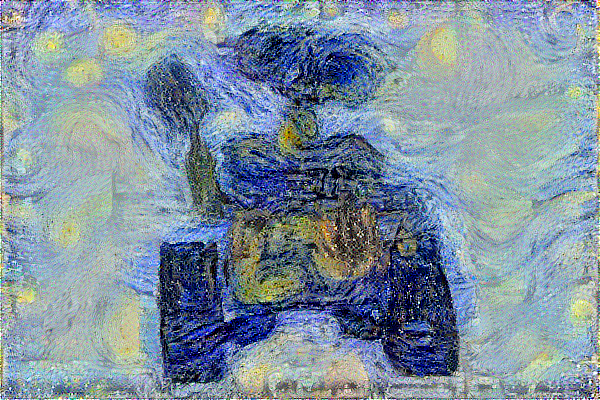

In [43]:
# Image in 2500th iter
Image.fromarray(imgs[2500])

In [49]:
# Function to display images
def display_images(content_path, style_path, generated_img):
  plt.figure(figsize=(20,20))

  content = load_img(content_path)
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  plt.imshow(content)
  plt.title('Content image')

  plt.subplot(1, 2, 2)
  plt.imshow(style)
  plt.title('Style image')
  plt.show()

  plt.imshow(generated_img)
  plt.title('Output Image')
  plt.show()

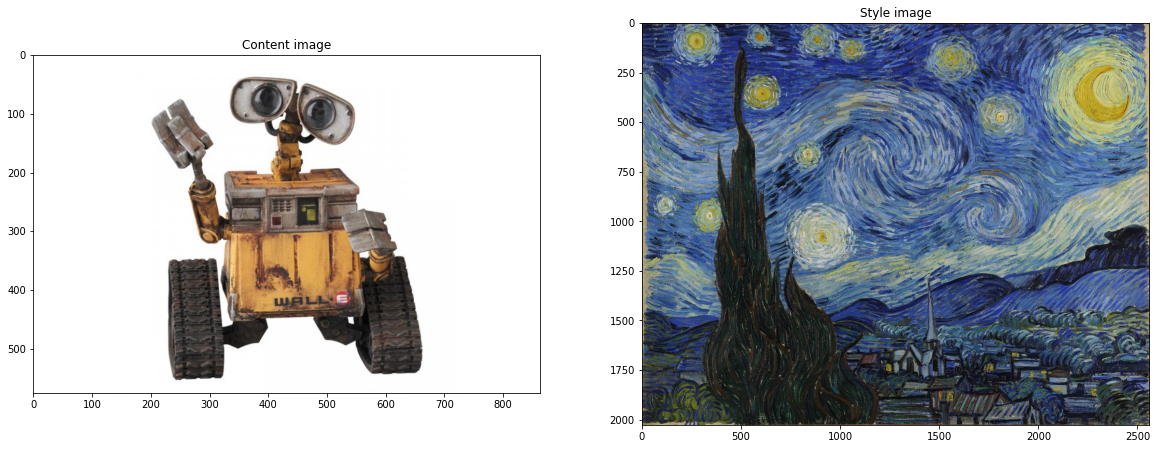

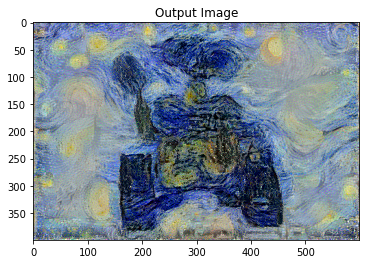

In [46]:
# Display image inputs

display_images(content_path, style_path, best_img)

Here are other images generated using other input:

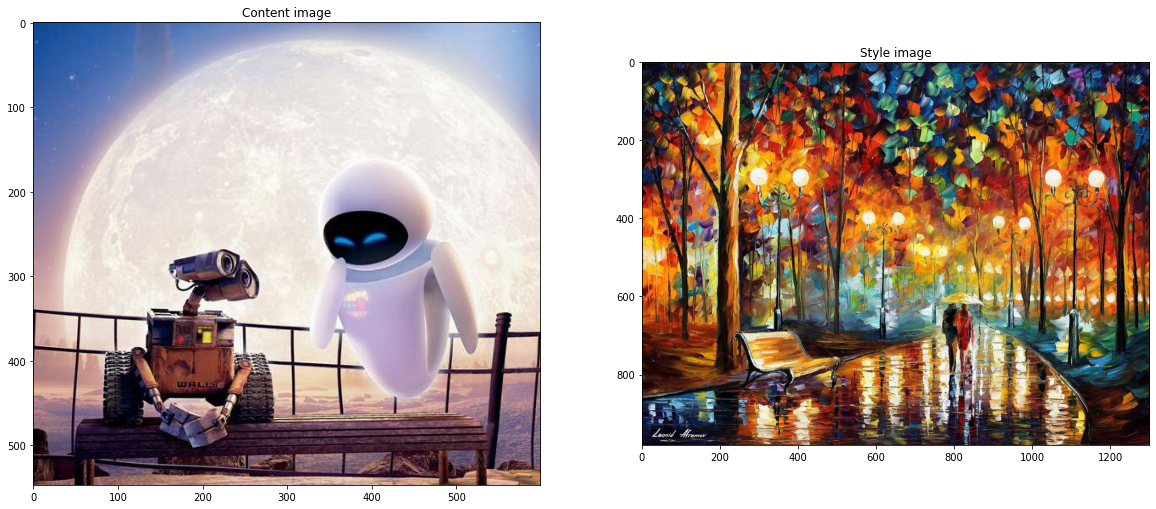

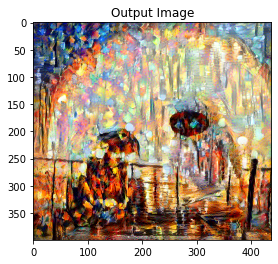

In [50]:
gen_1 = load_img('/wall_e_gen_rain_rustle.png')
display_images('/wall_e_eve_2.jpeg','/RAINS_RUSTLE_.jpeg', gen_1 )

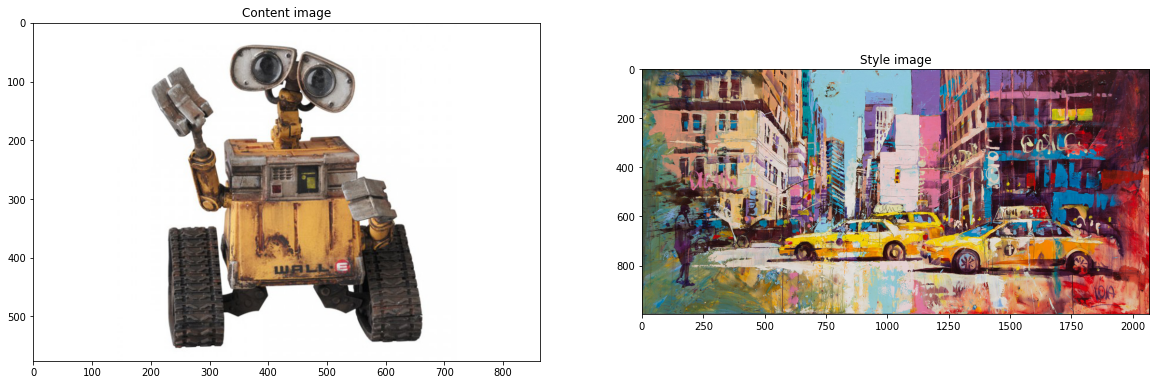

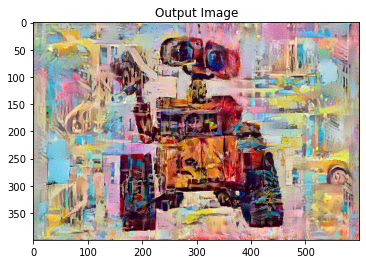

In [52]:
gen_2 = load_img('/wall_e_gen_voka_2.png')
display_images('/content/wall_e_5.jpeg', '/voka_2.jpeg', gen_2)

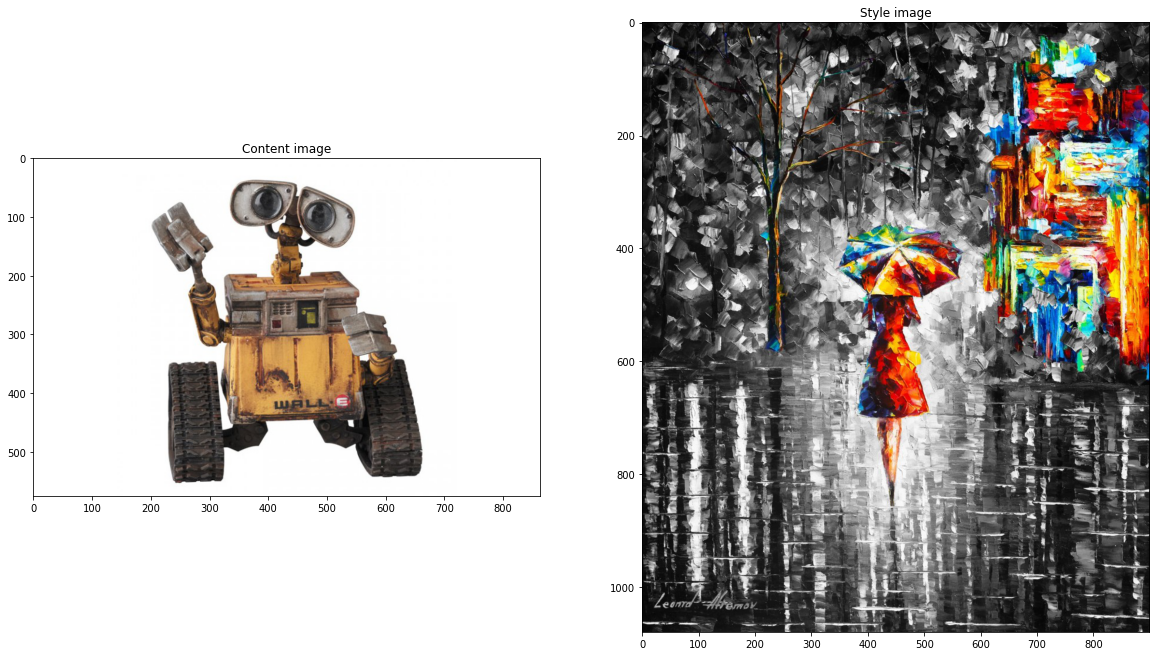

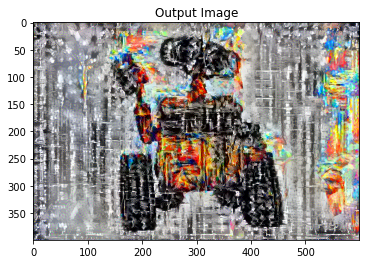

In [53]:
gen_3 = load_img('/wall_e_gen.png')
display_images('/content/wall_e_5.jpeg','/Rain_princess.jpeg' , gen_3)